# Open Images Instance Segmentation RVC 2020 edition
## Outline segmentation masks of objects in images

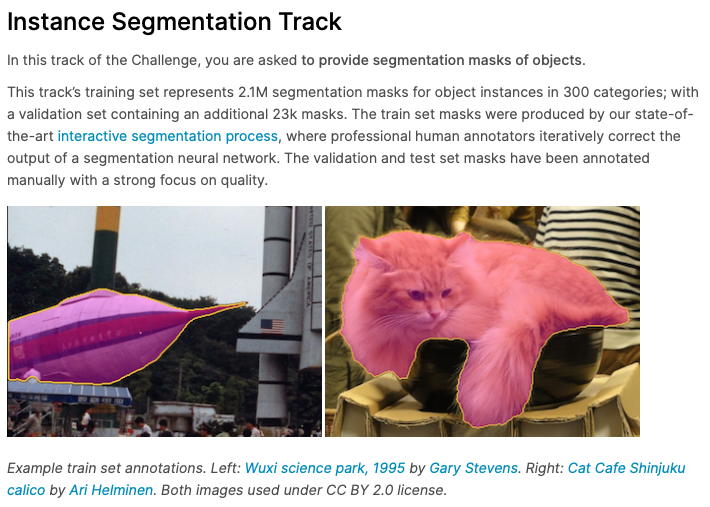

### Evaluation Metric

Submissions are evaluated by computing mean Average Precision, with the mean taken over the 300 segmentable classes of the challenge. It follows the same spirit as the Object Detection evaluation, but takes into account mask-to-mask matching.

[Acknowledgement : MaskRCNN](https://github.com/matterport/Mask_RCNN)

### We need to downgrade to TF 1.x in order to use MaskRCNN model

In [ ]:
!pip install tensorflow==1.15

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_hub as hub

In [ ]:
print(tf.__version__)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
%matplotlib inline
import cv2
from collections import defaultdict
from IPython.display import SVG
from tqdm.notebook import tqdm
from PIL import Image

In [ ]:
#import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

In [ ]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

In [ ]:
import sys
# Root directory of the project
#ROOT_DIR = os.path.abspath("../../")
ROOT_DIR = ('../kaggle/working/')
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log


# Directory to save logs and trained model
#MODEL_DIR = os.path.join(ROOT_DIR, "../output/kaggle/working/logs")
MODEL_DIR = ('../kaggle/working/Mask_RCNN')

# Local path to trained weights file
#COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
#if not os.path.exists(COCO_MODEL_PATH):
#    utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
class DetectorConfig(Config):
   
    # Configuration name  
    NAME = 'instances'
    
    # We have one GPU available, but can put multiple images on it
    # Batch size is 8 (GPUs * images/GPU)
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet101' #'resnet101' would be another option
    
    NUM_CLASSES = 2  # background + pneumonia classes -->semantic segmentation
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    TRAIN_ROIS_PER_IMAGE = 32 #or 16
    MAX_GT_INSTANCES = 4 #or 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  #or 0.7
    DETECTION_NMS_THRESHOLD = 0.01 #or 0.3
    STEPS_PER_EPOCH = 200 #or 500
    
config = DetectorConfig()
config.display()

In [ ]:
sys.path.append(os.path.join('Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
 
#!cd coco_weight && wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
#!ls -lh mask_rcnn_coco.h5
COCO_WEIGHTS_PATH = "/kaggle/working/Mask_RCNN/mask_rcnn_coco.h5"

In [ ]:
MODEL_DIR
COCO_WEIGHTS_PATH

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
image_path = '/kaggle/input/open-images-instance-segmentation-rvc-2020/test/'
file_list = os.listdir(image_path)
type(file_list)
test_df = pd.DataFrame(file_list)
test_df.rename(columns = {0:'image_ids'}, inplace = True)

In [ ]:
img = plt.imread( image_path + '00001a21632de752.jpg')
plt.imshow(img)
IMG_SHAPE = img.shape
print (IMG_SHAPE)

In [ ]:
def display_images(flnames):
    f, ax = plt.subplots(3,4, figsize=(20,40))
    image_path = '/kaggle/input/open-images-instance-segmentation-rvc-2020/test/'
    #for img in path.iterdir():

    for i, fl in enumerate(flnames):
        ax[i//4,i%4].set_axis_off()
        img = cv2.imread( image_path+fl)
        ax[i//4,i%4].imshow(img)
        ax[i//4,i%4].set_title(f'{fl}')
        f.tight_layout()

In [ ]:
display_images(list(test_df['image_ids'][:12]))

In [ ]:
'''
fig, axes = plt.subplots(10, figsize=(20,20))
for i in range(10):
    img = cv2.imread( image_path+test_df['image_ids'][i])
    axes[i].imshow(img)
''' 

In [ ]:
def resize_image(image):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [ ]:
#hs, ws = [], []
test_df['height'] = ""
test_df['weight'] = ""
#test_df = pd.DataFrame(file_list)
for i, row in tqdm(test_df.iterrows(), total = len(test_df)): #total = len(test_df)):
    img = Image.open(Path(path)/(test_df['image_ids'][i]))
    h, w = img.size
    test_df['height'][i] = h
    test_df['weight'][i] = w
    #hs.append(h)
    #ws.append(w)

In [ ]:
test_df.head(5)

In [ ]:
test_df.to_csv('/kaggle/working/test_df.csv')

In [ ]:
# example of inference with a pre-trained coco model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
 
# define 81 classes that the coco model knows about

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

#class_names = ['car','Car'] 
# define the test configuration
class ImgConfig(Config):
     NAME = "images"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 1 + 80

# define the model
rcnn = MaskRCNN(mode='inference', model_dir=MODEL_DIR, config=ImgConfig())
# load coco model weights
rcnn.load_weights(COCO_WEIGHTS_PATH, by_name=True)
# load image
img = load_img(image_path + test_df['image_ids'][29])
#print(img)
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# get dictionary for first prediction
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
#if (class_names == 'person'):
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

### Lets load another image and check

In [ ]:
# load image
img = load_img(image_path + test_df['image_ids'][15])
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# get dictionary for first prediction
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
#if (class_names == 'car'):
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

### Lets try One more gray image

In [ ]:
# load image
img = load_img(image_path + test_df['image_ids'][19])
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# get dictionary for first prediction
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
#if (class_names == 'car'):
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [ ]:
# load image
img = load_img(image_path + test_df['image_ids'][100])
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# get dictionary for first prediction
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
#if (class_names == 'car'):
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])